# This notebook compares MCS track statistics files between:
 - direct PyFLEXTRKR output
 - calculated from a mask file (make_mcs_stats_from_maaskfile.py)

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import copy
import seaborn as sns
from sklearn.neighbors import KernelDensity
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import shapely.geometry as sgeom
from itertools import chain
from scipy.ndimage import gaussian_filter
%matplotlib inline

In [2]:
PHASE = 'Summer'
# PHASE = 'Winter'

lifetime_bounds = [2,60]
region = 'tropics'

# PF land fraction threshold to separate land vs. ocean MCS
land_frac_thresh = 0.7
ocean_frac_thresh = 0.1

if PHASE == 'Summer':
    track_period = '20160801.0000_20160910.0000'
    datetime_range = pd.to_datetime(['2016-08-10T00', '2016-09-11T00'])
    lon_bounds = [-180, 180]
    lat_bounds = [-15, 30]
if PHASE == 'Winter':
    track_period = '20200120.0000_20200301.0000'
    datetime_range = pd.to_datetime(['2020-02-01T00', '2020-03-01T00'])
    lon_bounds = [-180, 180]
    # lon_bounds = [0, 360]
    lat_bounds = [-20, 15]
    
if PHASE == 'Summer':
    name_map = {
        'obs': 'OBS',
        'm1': 'NICAM',
        # 'm1': 'IFS',
    }

In [3]:
# runname = 'NICAM'
runname = 'OBS'
# runname = 'IFS'
dir_ref = f'/pscratch/sd/f/feng045/DYAMOND/{PHASE}/{runname}/stats/'
dir_mask = f'/pscratch/sd/f/feng045/DYAMOND/mcs_stats/{PHASE}/PyFLEXTRKR/'

file_ref = f'{dir_ref}mcs_tracks_robust_20160801.0000_20160910.0000.nc'
file_mask = f'{dir_mask}mcs_stats_{PHASE}_{runname}.nc'

## Custom functions for track selections

In [4]:
def find_track_in_region(start_basetime, lons, lats, lifetime, lon_bounds, lat_bounds, lifetime_bounds):
    """
    Find tracks within a period, region and lifetime bounds.
    """
    # Get the track initiation location
    start_lon = lons.isel(times=0)
    start_lat = lats.isel(times=0)

    # Find tracks that initiates within a region
    mcsidx = np.where(
        (start_basetime >= min(datetime_range)) & (start_basetime <= max(datetime_range)) & \
        (start_lon >= min(lon_bounds)) & (start_lon <= max(lon_bounds)) & \
        (start_lat >= min(lat_bounds)) & (start_lat <= max(lat_bounds)) & \
        (lifetime >= min(lifetime_bounds)) & (lifetime <= max(lifetime_bounds))
    )[0]
    return mcsidx

def get_land_ocean_ds(ds, trackidx, land_frac_thresh, ocean_frac_thresh):
    """
    Separate land vs. ocean tracks in Datasets.
    """
    # Subset tracks from Dataset
    ds = ds.isel(tracks=trackidx)

    # Calculate lifetime-mean PF land fraction
    init_landfrac = ds['pf_landfrac'].isel(times=slice(0,3)).mean(dim='times')
    avg_landfrac = ds['pf_landfrac'].mean(dim='times')
    # Separate land vs. ocean tracks
    mcsidx_land = np.where(avg_landfrac > land_frac_thresh)[0]
    mcsidx_ocean = np.where(avg_landfrac < ocean_frac_thresh)[0]
    # Subset tracks for land vs. ocean
    ds_l = ds.isel(tracks=mcsidx_land)
    ds_o = ds.isel(tracks=mcsidx_ocean)    
    return (ds_l, ds_o)

def find_merge_split_tracks(ds):
    """
    Find merge/split track indices.
    """
    # non-split tracks
    idx_nsplit = np.isnan(ds.start_split_cloudnumber)
    # non-merge tracks
    idx_nmerge = np.isnan(ds.end_merge_cloudnumber)
    # non-merge and non-split tracks
    idx_nms = np.isnan(ds.start_split_cloudnumber) & np.isnan(ds.end_merge_cloudnumber)
    # merge or split tracks
    idx_ms = ~np.isnan(ds.start_split_cloudnumber) | ~np.isnan(ds.end_merge_cloudnumber)
    # Group outputs to dictionary
    out_dict = {
        'ms': idx_ms,
        'nms': idx_nms,
        'nm': idx_nmerge,
        'ns': idx_nsplit,
    }
    return out_dict

## Functions to count unique track numbers on a grid

In [5]:
def get_unique_placements(track_num, lat, lon, ntimes):
    """
    Get unique pairs of lat/lon for a track
    """
    # Put all lat/lon pairs over each time for a track into an array
    this_row = np.array([[lat[track_num, tt], lon[track_num, tt]] for tt in range(0, ntimes)])
    # Return the unique pairs (axis=0)
    return np.array(np.unique(this_row, axis=0))

def count_unique_mcs(lat, lon, xbins, ybins):
    
    ntracks, ntimes = lat.shape

    # A function to loop over tracks
    get_unique = lambda D: get_unique_placements(D, lat, lon, ntimes)

    # Loop over each track and get the unique pairs of lat/lon
    all_uniques = list(map(get_unique, np.arange(0, ntracks)))

    # Flatten the list of lat/lon pairs (using chain), and convert into an array
    unique_latlon = np.array(list(chain(*all_uniques)))

    # Count number on map using histogram2d
    ranges = [[min(ybins), max(ybins)], [min(xbins), max(xbins)]]
    hist2d, yedges, xedges = np.histogram2d(unique_latlon[:,0], unique_latlon[:,1], bins=[ybins, xbins], range=ranges)

    return hist2d

In [6]:
# Read OBS MCS data
dsobs = xr.open_dataset(file_ref)
time_res_obs = dsobs.attrs['time_resolution_hour']
pixel_radius_obs = dsobs.attrs['pixel_radius_km']
dsobs

<xarray.Dataset>
Dimensions:                  (tracks: 4291, times: 500, mergers: 50, nmaxpf: 3)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 4 ... 4287 4288 4289 4290
  * times                    (times) int64 0 1 2 3 4 5 ... 495 496 497 498 499
  * mergers                  (mergers) int64 0 1 2 3 4 5 6 ... 44 45 46 47 48 49
  * nmaxpf                   (nmaxpf) int64 0 1 2
Data variables: (12/55)
    track_duration           (tracks) int32 ...
    start_status             (tracks) float64 ...
    end_status               (tracks) float64 ...
    start_basetime           (tracks) datetime64[ns] ...
    end_basetime             (tracks) datetime64[ns] ...
    start_split_cloudnumber  (tracks) float64 ...
    ...                       ...
    pf_landfrac              (tracks, times) float32 ...
    total_rain               (tracks, times) float32 ...
    total_heavyrain          (tracks, times) float32 ...
    rainrate_heavyrain       (tracks, times) float32 ...
    pf_lifetime              (tracks) float32 ...
    pf_mcsstatus             (tracks, times) float64 ...
Attributes: (12/20)
    Title:                        Statistics of each MCS track
    Institution:                  Pacific Northwest National Laboratory
    Contact:                      Zhe Feng, zhe.feng@pnnl.gov
    Created_on:                   Thu Aug 24 23:08:56 2023
    startdate:                    20160801.0000
    enddate:                      20160910.0000
    ...                           ...
    landfrac_thresh:              [ 0 90]
    MCS_PF_majoraxis_thresh:      0
    MCS_PF_duration_thresh:       4
    PF_PF_min_majoraxis_thresh:   20
    mcs_min_rainvol_thresh:       20000
    mcs_volrain_duration_thresh:  1.0

In [7]:
# Read m1 data
dsm1 = xr.open_dataset(file_mask)
# time_res_m1 = dsm1.attrs['time_resolution_hour']
time_res_m1 = time_res_obs
pixel_radius_m1 = dsm1.attrs['pixel_radius_km']
dsm1

<xarray.Dataset>
Dimensions:                  (tracks: 4291, times: 500, nmaxpf: 3)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 4 ... 4287 4288 4289 4290
  * times                    (times) int64 0 1 2 3 4 5 ... 495 496 497 498 499
  * nmaxpf                   (nmaxpf) int64 0 1 2
Data variables: (12/38)
    track_duration           (tracks) int64 ...
    start_basetime           (tracks) datetime64[ns] ...
    end_basetime             (tracks) datetime64[ns] ...
    base_time                (tracks, times) datetime64[ns] ...
    core_area                (tracks, times) float32 ...
    cold_area                (tracks, times) float32 ...
    ...                       ...
    pf_accumrain             (tracks, times, nmaxpf) float32 ...
    pf_accumrainheavy        (tracks, times, nmaxpf) float32 ...
    pf_landfrac              (tracks, times) float32 ...
    total_rain               (tracks, times) float32 ...
    total_heavyrain          (tracks, times) float32 ...
    rainrate_heavyrain       (tracks, times) float32 ...
Attributes:
    pixel_radius_km:        10.0
    time_resolution_hour:   1.0
    tb_core_thresh:         225.0
    tb_cold_thresh:         241.0
    nmaxpf:                 3
    PF_rainrate_thresh:     2.0
    heavy_rainrate_thresh:  10.0
    landfrac_thresh:        [ 0 90]
    Created_on:             Mon Oct 23 14:38:31 2023

In [8]:
# Round the lat/lon to the nearest integer, 
# This way the lat/lon are calculated at the precision of 1 degree (i.e., count on a 1x1 degree grid)
# Note: counting using histogram2d only works on 1x1 degree grid (unique lat/lon are round to integer)
rlat_obs = dsobs.meanlat.load().round().data
rlon_obs = dsobs.meanlon.load().round().data

lat0_obs = dsobs.meanlat
lon0_obs = dsobs.meanlon

# For Winter, convert longitudes from -180~+180 to 0~360
if (PHASE == 'Winter') & (np.nanmin(lon0_obs) < 0):
    rlon_obs = rlon_obs % 360
    lon0_obs = lon0_obs % 360

In [9]:
# Round the lat/lon to the nearest integer, 
# This way the lat/lon are calculated at the precision of 1 degree (i.e., count on a 1x1 degree grid)
# Note: counting using histogram2d only works on 1x1 degree grid (unique lat/lon are round to integer)
rlat_m1 = dsm1.meanlat.load().round().data
rlon_m1 = dsm1.meanlon.load().round().data

lat0_m1 = dsm1.meanlat.isel(times=0)
lon0_m1 = dsm1.meanlon.isel(times=0)

# For Winter, convert longitudes from -180~+180 to 0~360
if (PHASE == 'Winter') & (np.nanmin(lon0_m1) < 0):
    rlon_m1 = rlon_m1 % 360
    lon0_m1 = lon0_m1 % 360

In [10]:
if PHASE == 'Winter':
    ranges = [[-60,60], [0,360]]
    xbins = np.arange(0, 360.1, 1)
    ybins = np.arange(-60., 60.1, 1)

    xbins5 = np.arange(0,361,5)
    ybins5 = np.arange(-60,61,5)
    ranges5 = [[min(ybins5), max(ybins5)], [min(xbins5), max(xbins5)]]

elif PHASE == 'Summer':
    ranges = [[-60,60], [-180,180]]
    xbins = np.arange(-180, 180.1, 1)
    ybins = np.arange(-60., 60.1, 1)

    xbins5 = np.arange(-180,181,5)
    ybins5 = np.arange(-60,61,5)
    ranges5 = [[min(ybins5), max(ybins5)], [min(xbins5), max(xbins5)]]

In [11]:
# Total MCS count
mcs_irnumber_obs = count_unique_mcs(rlat_obs, rlon_obs, xbins, ybins)
mcs_irnumber_m1 = count_unique_mcs(rlat_m1, rlon_m1, xbins, ybins)

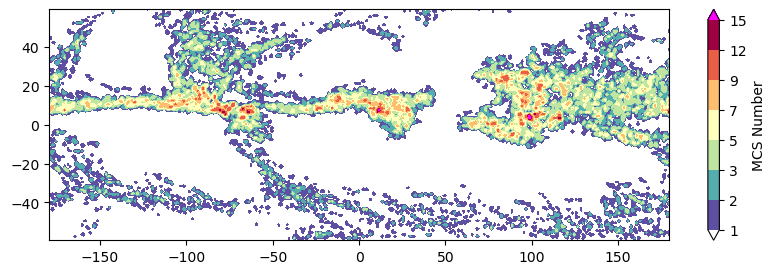

In [12]:
fig = plt.figure(figsize=[10,3], dpi=100)
levels = [1,2,3,5,7,9,12,15]
cmap = copy.copy(mpl.colormaps.get_cmap("Spectral_r"))
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=256)
# pcm = plt.pcolormesh(xbins, ybins, mcs_irnumber_obs, norm=norm, cmap=cmap)
lonbins = xbins[:-1] + np.diff(xbins)/2.
latbins = ybins[:-1] + np.diff(ybins)/2.
cmap.set_over('magenta')
cmap.set_under('white')
pcm = plt.contourf(lonbins, latbins, mcs_irnumber_obs, levels=levels, norm=norm, cmap=cmap, extend='both')
plt.colorbar(label='MCS Number')

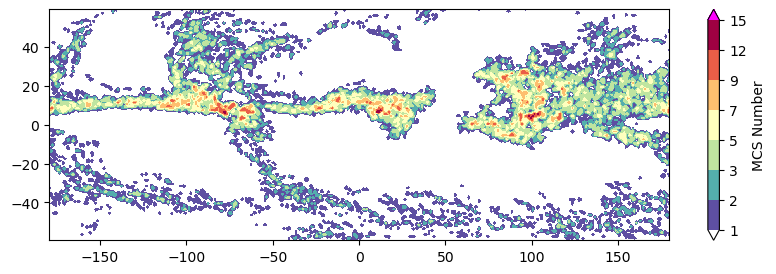

In [13]:
fig = plt.figure(figsize=[10,3], dpi=100)
# levels = [1,2,4,7,10,13,16,20]
levels = [1,2,3,5,7,9,12,15]
cmap = copy.copy(mpl.colormaps.get_cmap("Spectral_r"))
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=256)
# pcm = plt.pcolormesh(xbins, ybins, mcs_irnumber_m1, norm=norm, cmap=cmap)
lonbins = xbins[:-1] + np.diff(xbins)/2.
latbins = ybins[:-1] + np.diff(ybins)/2.
cmap.set_over('magenta')
cmap.set_under('white')
pcm = plt.contourf(lonbins, latbins, mcs_irnumber_m1, levels=levels, norm=norm, cmap=cmap, extend='both')
plt.colorbar(label='MCS Number')

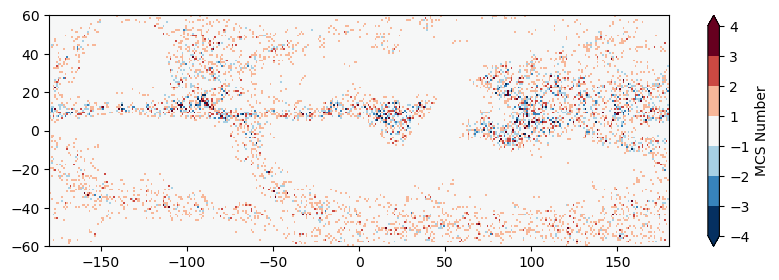

In [14]:
diff = mcs_irnumber_m1 - mcs_irnumber_obs
diffs = gaussian_filter(diff, 1.0)

# Calculate lat/lon bin center value
lonbins = xbins[:-1] + np.diff(xbins)/2.
latbins = ybins[:-1] + np.diff(ybins)/2.
lonbins2d, latbins2d = np.meshgrid(lonbins, latbins)

fig = plt.figure(figsize=[10,3], dpi=100)
levels = [-4,-3,-2,-1,1,2,3,4]
cbticks = levels
cmap = copy.copy(mpl.colormaps.get_cmap('RdBu_r'))
norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N)
plt.pcolormesh(lonbins, latbins, diff, norm=norm, cmap=cmap)
plt.colorbar(label='MCS Number', extend='both')

## Subset MCS tracks by region and time

In [15]:
# OBS
mcsidx_obs = find_track_in_region(dsobs.start_basetime, dsobs.meanlon, dsobs.meanlat, dsobs.track_duration*time_res_obs, lon_bounds, lat_bounds, lifetime_bounds)
print('Number of MCS (OBS): ', len(mcsidx_obs))

# Model m1
mcsidx_m1 = find_track_in_region(dsm1.start_basetime, dsm1.meanlon, dsm1.meanlat, dsm1.track_duration*time_res_m1, lon_bounds, lat_bounds, lifetime_bounds)
print(f'Number of MCS ({name_map["m1"]}): ', len(mcsidx_m1))

Number of MCS (OBS):  2497
Number of MCS (NICAM):  2497


In [16]:
# Subset tracks in OBS
dsobs_s = dsobs.isel(tracks=mcsidx_obs)

In [17]:
# Subset tracks using the same track indices as OBS
dsm1_s = dsm1.isel(tracks=mcsidx_obs)

In [18]:
# Location with min Tb
lon_mintb_obs = dsobs_s.lon_mintb
lat_mintb_obs = dsobs_s.lat_mintb
lat_mintb_obs = dsobs_s.lat_mintb
lat_mintb_obs = dsobs_s.lat_mintb

lon_mintb_m1 = dsm1_s.lon_mintb
lat_mintb_m1 = dsm1_s.lat_mintb
lat_mintb_m1 = dsm1_s.lat_mintb
lat_mintb_m1 = dsm1_s.lat_mintb

(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 4.000e+00,
        2.800e+01, 2.300e+01, 2.000e+01, 3.700e+01, 1.450e+02, 3.100e+02,
        4.490e+02, 7.650e+02, 1.386e+03, 1.252e+03, 1.385e+03, 1.722e+03,
        1.671e+03, 1.883e+03, 2.357e+03, 3.588e+03, 4.653e+03, 4.935e+03,
        3.718e+03, 2.708e+03, 2.056e+03, 1.932e+03, 1.854e+03, 1.603e+03,
        1.670e+03, 1.351e+03, 8.220e+02, 3.870e+02, 7.100e+01, 2.800e+01,
        1.800e+01, 5.000e+00, 7.000e+00, 2.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
 array([-60., -58., -56., -54., -52., -50., -48., -46., -44., -42., -40.,
        -38., -36., -34., -32., -30., -28., -26., -24., -22., -20., -18.,
        -16., -14., -12., -10.,  -8.,  -6.,  -4.,  -2.,   0.,   2.,   4.,
          6.,   8.,  10.,  12.,  14.,  16.,  18

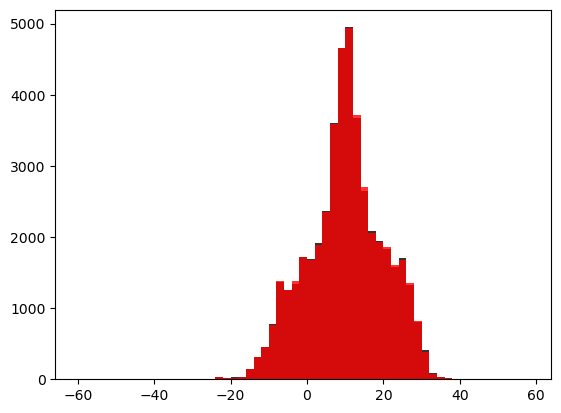

In [19]:
lat_bins = np.arange(-60, 60, 2)
plt.hist(lat_mintb_obs.data.flatten(), bins=lat_bins, color='k', alpha=0.8)
plt.hist(lat_mintb_m1.data.flatten(), bins=lat_bins, color='r', alpha=0.8)

(array([397., 337., 256., 205., 161., 149., 160., 183., 144., 155., 182.,
        207., 148., 129., 107.,  80.,  93., 124.,  95., 107., 130., 106.,
        132., 189., 114., 145., 126., 114., 110.,  86., 114., 114., 122.,
        136., 199., 329., 377., 362., 355., 271., 331., 349., 421., 359.,
        258., 316., 331., 279., 382., 341., 366., 415., 348., 405., 278.,
        360., 351., 385., 367., 357., 261., 212., 167., 166., 130.,  91.,
        108., 104.,  58.,  50.,  79.,  81., 117., 111., 139., 100., 107.,
        140., 135., 105., 161., 206., 174., 236., 221., 173., 143., 138.,
        118., 141., 160., 149., 195., 269., 274., 296., 286., 267., 274.,
        293., 380., 341., 289., 309., 214.,  83., 133., 107.,  88.,  38.,
         41.,  60.,   2.,   0.,   0.,   0.,   0.,   2.,  30., 110.,  79.,
        124., 181., 213., 194., 242., 242., 217., 293., 316., 419., 375.,
        391., 453., 546., 599., 588., 636., 600., 592., 575., 687., 562.,
        452., 381., 374., 381., 388., 

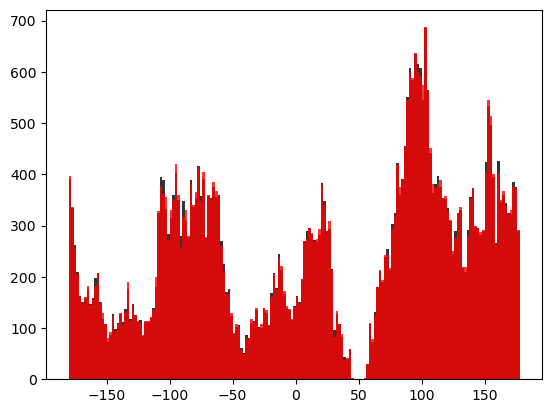

In [20]:
lon_bins = np.arange(-180, 180, 2)
plt.hist(lon_mintb_obs.data.flatten(), bins=lon_bins, color='k', alpha=0.8)
plt.hist(lon_mintb_m1.data.flatten(), bins=lon_bins, color='r', alpha=0.8)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-180, -178, -176, -174, -172, -170, -168, -166, -164, -162, -160,
        -158, -156, -154, -152, -150, -148, -146, -144, -142, -140, -138,
        -136, -134, -132, -130, -128, -126, -124, -122, -120, -118, -116,
        -114, -112, -110, -108, -106, -104, -102, -100,  -98,  -96,  -94,
         -92,  -90,  -88,  -86,  -84,  -82,  -80,  -78,  -76,  -74,  -72,
         -70,  -68,  -66,  -64,  -62,  -60,  -58,  -56,  -54,  -52,  -50,
         -48,  -46,  -44,  -42,  -40,  -38,  -36,  -34,  -32,  -30,  -28,
         -26,  -24,  -22,  -20,  -18,  -16,  -14,  -12,  -10,   -8,   -6,
          -4,   -2,    0,    2,    4,    6,    8,   10,   12,   14,   16,
          18,   20,   22,   24,   26,   28,   30,   32,   34,   36,   38,
          4

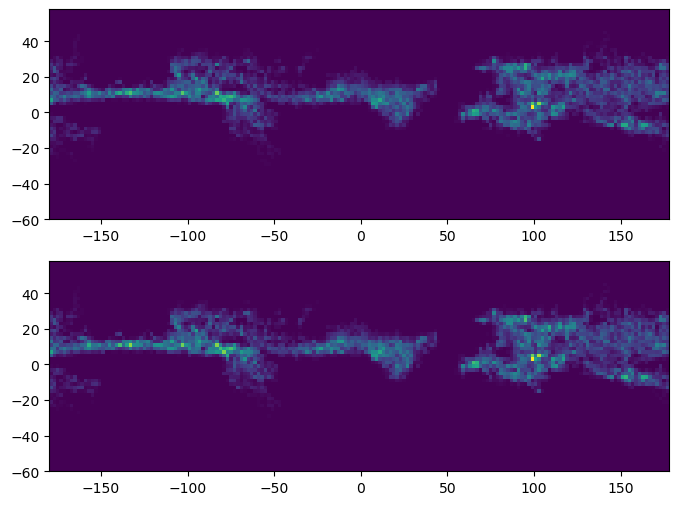

In [21]:
fig, axes = plt.subplots(2, 1, figsize=[8,6], dpi=100)
ax = axes[0]
ax.hist2d(lon_mintb_obs.data.flatten(), lat_mintb_obs.data.flatten(), bins=[lon_bins,lat_bins], )
ax = axes[1]
ax.hist2d(lon_mintb_m1.data.flatten(), lat_mintb_m1.data.flatten(), bins=[lon_bins,lat_bins], )

In [22]:
def get_kde1d(data, bins, kde_bw, kde_kernel='gaussian'):
    """
    Compute 1D KDE using Ski-learn
    
    Args:
        data: np.array
            Array containing data.
        bins: np.array
            Desired bins for plotting.
        kde_bw: float
            The bandwidth of the kernel.
        kde_kernel: string
            The kernel to use.
            
    Return:
        kde_out: np.array
            KDE at the desired bins.
    """
    # Flatten array to 1D
    data1d = data.flatten()
    # Remove NaN (sklearn KDE does not handle NaN), and make a new axis
    _data = data1d[~np.isnan(data1d)][:, np.newaxis]
    _bins = bins[:, np.newaxis]
    
    # Estimate 1D KDE following sklearn example
    # https://scikit-learn.org/stable/auto_examples/neighbors/plot_kde_1d.html
    kde = KernelDensity(kernel=kde_kernel, bandwidth=kde_bw).fit(_data)
    # Get KDE values based on input bins
    log_dens = kde.score_samples(_bins)
    # Get linear density
    kde_out = np.exp(log_dens)
    return kde_out

In [23]:
lifetime_bins = np.linspace(0, 100, 1000)
kde_ccslifetime_obs = get_kde1d((dsobs_s.track_duration * time_res_obs).data, lifetime_bins, kde_bw=3)
kde_ccslifetime_m1 = get_kde1d((dsm1_s.track_duration * time_res_m1).data, lifetime_bins, kde_bw=3)

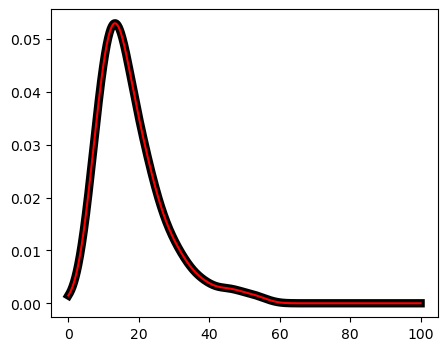

In [24]:
fig, ax = plt.subplots(1, 1, figsize=[5,4], dpi=100)
ax.plot(lifetime_bins, kde_ccslifetime_obs, 'k', lw=6)
ax.plot(lifetime_bins, kde_ccslifetime_m1, 'r')

In [25]:
dsobs_s.ccs_area

<xarray.DataArray 'ccs_area' (tracks: 2497, times: 500)>
[1248500 values with dtype=float32]
Coordinates:
  * tracks   (tracks) int64 1001 1002 1005 1007 1008 ... 4287 4288 4289 4290
  * times    (times) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
Attributes:
    long_name:  Area of cold cloud shield
    units:      km^2

In [26]:
dsobs_s.merge_ccs_area.sum(dim='mergers')

<xarray.DataArray 'merge_ccs_area' (tracks: 2497, times: 500)>
array([[    0.,  1000.,     0., ...,     0.,     0.,     0.],
       [39600., 70600., 82200., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       ...,
       [26100., 11400., 22500., ...,     0.,     0.,     0.],
       [    0.,  2300.,     0., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.]],
      dtype=float32)
Coordinates:
  * tracks   (tracks) int64 1001 1002 1005 1007 1008 ... 4287 4288 4289 4290
  * times    (times) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499

In [27]:
ccsarea_bins = np.linspace(4, 6.8, 1000)
# Add mergers/splits to get total CCS area
ccsarea_obs = dsobs_s.ccs_area + dsobs_s.merge_ccs_area.sum(dim='mergers') + dsobs_s.split_ccs_area.sum(dim='mergers')
mergesplit_ccsarea_obs = dsobs_s.merge_ccs_area.sum(dim='mergers') + dsobs_s.split_ccs_area.sum(dim='mergers')
mergesplit_ccsarea_obs = mergesplit_ccsarea_obs.where(mergesplit_ccsarea_obs > 0, other=np.NaN)
maxccsarea_obs = ccsarea_obs.max(dim='times')
mergesplit_maxccsarea_obs = mergesplit_ccsarea_obs.max(dim='times')

# CCS area already includes merge/splits
maxccsarea_m1 = dsm1_s.ccs_area.max(dim='times')

kde_maxccsarea_obs = get_kde1d(np.log10(maxccsarea_obs.data), ccsarea_bins, kde_bw=0.2)
kde_mergesplit_maxccsarea_obs = get_kde1d(np.log10(mergesplit_maxccsarea_obs.data), ccsarea_bins, kde_bw=0.2)
kde_maxccsarea_m1 = get_kde1d(np.log10(maxccsarea_m1.data), ccsarea_bins, kde_bw=0.2)

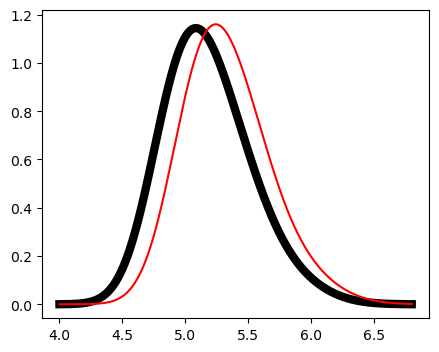

In [29]:
fig, ax = plt.subplots(1, 1, figsize=[5,4], dpi=100)
ax.plot(ccsarea_bins, kde_maxccsarea_obs, 'k', lw=6)
# ax.plot(ccsarea_bins, kde_mergesplit_maxccsarea_obs, 'b')
ax.plot(ccsarea_bins, kde_maxccsarea_m1, 'r')

In [30]:
pfarea_bins = np.linspace(3.3, 6, 1000)
# Sum all PFs at a given time, then take max during lifetime
maxpfarea_obs = dsobs_s.pf_area.sum(dim='nmaxpf').max(dim='times')
maxpfarea_m1 = dsm1_s.pf_area.sum(dim='nmaxpf').max(dim='times')

kde_maxpfarea_obs = get_kde1d(np.log10(maxpfarea_obs.data), pfarea_bins, kde_bw=0.2)
kde_maxpfarea_m1 = get_kde1d(np.log10(maxpfarea_m1.data), pfarea_bins, kde_bw=0.2)

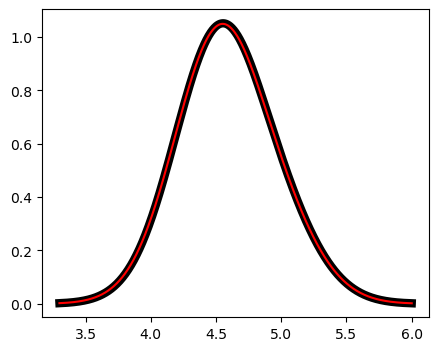

In [31]:
fig, ax = plt.subplots(1, 1, figsize=[5,4], dpi=100)
ax.plot(pfarea_bins, kde_maxpfarea_obs, 'k', lw=6)
ax.plot(pfarea_bins, kde_maxpfarea_m1, 'r')

In [32]:
pfrainrate_bins = np.linspace(2, 20, 1000)
kde_meanpfrainrate_obs = get_kde1d(dsobs_s.pf_rainrate.isel(nmaxpf=0).mean(dim='times').data, pfrainrate_bins, kde_bw=0.5)
kde_meanpfrainrate_m1 = get_kde1d(dsm1_s.pf_rainrate.isel(nmaxpf=0).mean(dim='times').data, pfrainrate_bins, kde_bw=0.5)

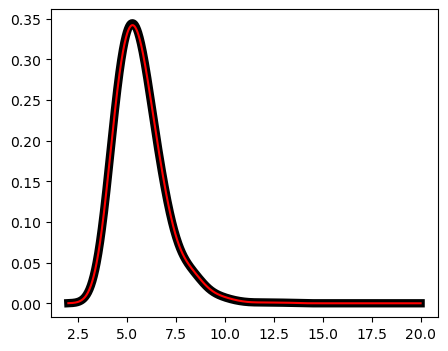

In [33]:
fig, ax = plt.subplots(1, 1, figsize=[5,4], dpi=100)
ax.plot(pfrainrate_bins, kde_meanpfrainrate_obs, 'k', lw=6)
ax.plot(pfrainrate_bins, kde_meanpfrainrate_m1, 'r')

In [34]:
avgmintb_bins = np.linspace(180, 230, 1000)
kde_avgmintb_obs = get_kde1d(dsobs_s.corecold_mintb.mean(dim='times').data, avgmintb_bins, kde_bw=2)
kde_avgmintb_m1 = get_kde1d(dsm1_s.corecold_mintb.mean(dim='times').data, avgmintb_bins, kde_bw=2)

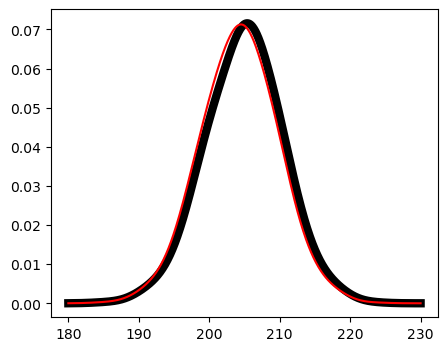

In [35]:
fig, ax = plt.subplots(1, 1, figsize=[5,4], dpi=100)
ax.plot(avgmintb_bins, kde_avgmintb_obs, 'k', lw=6)
ax.plot(avgmintb_bins, kde_avgmintb_m1, 'r')

In [36]:
mintb_bins = np.linspace(170, 220, 1000)
kde_mintb_obs = get_kde1d(dsobs_s.corecold_mintb.min(dim='times').data, mintb_bins, kde_bw=2)
kde_mintb_m1 = get_kde1d(dsm1_s.corecold_mintb.min(dim='times').data, mintb_bins, kde_bw=2)

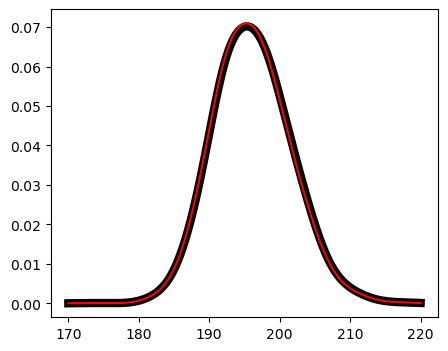

In [37]:
fig, ax = plt.subplots(1, 1, figsize=[5,4], dpi=100)
ax.plot(mintb_bins, kde_mintb_obs, 'k', lw=6)
ax.plot(mintb_bins, kde_mintb_m1, 'r')

In [38]:
pfvolrain_obs = dsobs_s.total_rain.sum(dim='times') * pixel_radius_obs**2
pfvolrain_m1 = dsm1_s.total_rain.sum(dim='times') * pixel_radius_m1**2

volrain_bins = np.linspace(5, 8.5, 1000)
# Ocean
kde_pfvolrain_obs = get_kde1d(np.log10(pfvolrain_obs.data), volrain_bins, kde_bw=0.2)
kde_pfvolrain_m1 = get_kde1d(np.log10(pfvolrain_m1.data), volrain_bins, kde_bw=0.2)

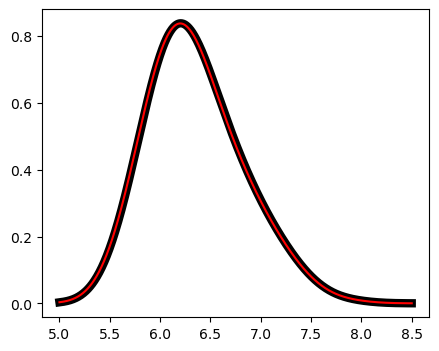

In [39]:
fig, ax = plt.subplots(1, 1, figsize=[5,4], dpi=100)
ax.plot(volrain_bins, kde_pfvolrain_obs, 'k', lw=6)
ax.plot(volrain_bins, kde_pfvolrain_m1, 'r')

In [40]:
pfheavyvolrain_obs = dsobs_s.total_heavyrain.sum(dim='times') * pixel_radius_obs**2
pfheavyvolrain_m1 = dsm1_s.total_heavyrain.sum(dim='times') * pixel_radius_m1**2

heavyvolrain_bins = np.linspace(4, 8, 1000)
kde_pfheavyvolrain_obs = get_kde1d(np.log10(pfheavyvolrain_obs.data), heavyvolrain_bins, kde_bw=0.2)
kde_pfheavyvolrain_m1 = get_kde1d(np.log10(pfheavyvolrain_m1.data), heavyvolrain_bins, kde_bw=0.2)

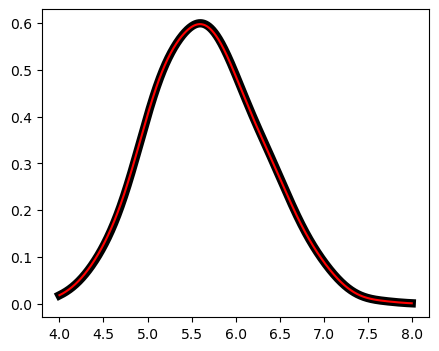

In [41]:
fig, ax = plt.subplots(1, 1, figsize=[5,4], dpi=100)
ax.plot(heavyvolrain_bins, kde_pfheavyvolrain_obs, 'k', lw=6)
ax.plot(heavyvolrain_bins, kde_pfheavyvolrain_m1, 'r')

In [42]:
# Heavy rain volume ratio (heavy rain vol. / total rain vol.)
pfhrr_obs = 100 * pfheavyvolrain_obs / pfvolrain_obs
pfhrr_m1 = 100 * pfheavyvolrain_m1 / pfvolrain_m1

pfhrr_bins = np.linspace(0, 100, 1000)
kde_pfhrr_obs = get_kde1d(pfhrr_obs.data, pfhrr_bins, kde_bw=4)
kde_pfhrr_m1 = get_kde1d(pfhrr_m1.data, pfhrr_bins, kde_bw=4)

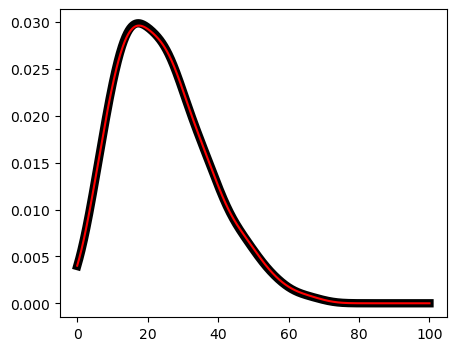

In [43]:
fig, ax = plt.subplots(1, 1, figsize=[5,4], dpi=100)
ax.plot(pfhrr_bins, kde_pfhrr_obs, 'k', lw=6)
ax.plot(pfhrr_bins, kde_pfhrr_m1, 'r')

## Function to composite track time-evolution by 1 condition

In [44]:
import warnings
def get_comp_tracks_by1cond(in_var, x_cond_var, x_cond_range, quantiles):
    # Suppress RuntimeWarning
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        # Filter by one condition range
        in_var_cond = in_var.where((x_cond_var >= x_cond_range[0]) & (x_cond_var <= x_cond_range[1]), drop=True)
        nsamples = in_var_cond.sizes['tracks']
        out_var_mean = in_var_cond.mean(dim='tracks')
        out_var_qntl = in_var_cond.quantile(quantiles, dim='tracks')
    return out_var_mean, out_var_qntl, nsamples

In [58]:
# Set composite quantiles and lifetime range
quantiles = [0.25, 0.5, 0.75]
# lifetime_range1 = [8, 14]
lifetime_range1 = [8, 10]
lifetime_range2 = [22, 24]

In [59]:
# CCS lifetime
ccslifetime_obs = dsobs_s.track_duration*time_res_obs
ccslifetime_m1 = dsm1_s.track_duration*time_res_m1

# Add mergers/splits to get total CCS area
ccsarea_obs = dsobs_s.ccs_area + dsobs_s.merge_ccs_area.sum(dim='mergers') + dsobs_s.split_ccs_area.sum(dim='mergers')
ccsarea_m1 = dsm1_s.ccs_area

avg1_ccsarea_obs, qntl1_ccsarea_obs, ns1_obs = get_comp_tracks_by1cond(ccsarea_obs, ccslifetime_obs, lifetime_range1, quantiles)
avg1_ccsarea_m1, qntl1_ccsarea_m1, ns1_m1 = get_comp_tracks_by1cond(ccsarea_m1, ccslifetime_m1, lifetime_range1, quantiles)

avg2_ccsarea_obs, qntl2_ccsarea_obs, ns2_obs = get_comp_tracks_by1cond(ccsarea_obs, ccslifetime_obs, lifetime_range2, quantiles)
avg2_ccsarea_m1, qntl2_ccsarea_m1, ns2_m1 = get_comp_tracks_by1cond(ccsarea_m1, ccslifetime_m1, lifetime_range2, quantiles)

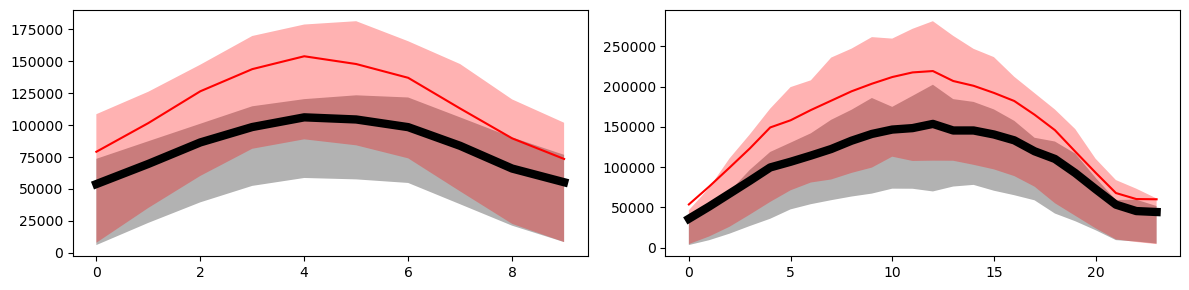

In [60]:
xx_obs = avg1_ccsarea_obs.times
xx_m1 = avg1_ccsarea_m1.times

fig, axes = plt.subplots(1, 2, figsize=[12,3], dpi=100)
ax = axes[0]
ax.plot(xx_obs, avg1_ccsarea_obs, 'k', lw=6)
ax.plot(xx_m1, avg1_ccsarea_m1, 'r')
# Shading
qntl25 = qntl1_ccsarea_obs.sel(quantile=0.25)
qntl75 = qntl1_ccsarea_obs.sel(quantile=0.75)
ax.fill_between(xx_obs, qntl25, qntl75, facecolor='k', alpha=0.3)
qntl25 = qntl1_ccsarea_m1.sel(quantile=0.25)
qntl75 = qntl1_ccsarea_m1.sel(quantile=0.75)
ax.fill_between(xx_m1, qntl25, qntl75, facecolor='r', alpha=0.3)

ax = axes[1]
ax.plot(xx_obs, avg2_ccsarea_obs, 'k', lw=6)
ax.plot(xx_m1, avg2_ccsarea_m1, 'r')
# Shading
qntl25 = qntl2_ccsarea_obs.sel(quantile=0.25)
qntl75 = qntl2_ccsarea_obs.sel(quantile=0.75)
ax.fill_between(xx_obs, qntl25, qntl75, facecolor='k', alpha=0.3)
qntl25 = qntl2_ccsarea_m1.sel(quantile=0.25)
qntl75 = qntl2_ccsarea_m1.sel(quantile=0.75)
ax.fill_between(xx_m1, qntl25, qntl75, facecolor='r', alpha=0.3)
fig.tight_layout()

In [61]:
# Largest PF area
avg1_pfarea_obs, qntl1_pfarea_obs, ns1_obs = get_comp_tracks_by1cond(dsobs_s.pf_area.isel(nmaxpf=0), ccslifetime_obs, lifetime_range1, quantiles)
avg1_pfarea_m1, qntl1_pfarea_m1, ns1_m1 = get_comp_tracks_by1cond(dsm1_s.pf_area.isel(nmaxpf=0), ccslifetime_m1, lifetime_range1, quantiles)

avg2_pfarea_obs, qntl2_pfarea_obs, ns2_obs = get_comp_tracks_by1cond(dsobs_s.pf_area.isel(nmaxpf=0), ccslifetime_obs, lifetime_range2, quantiles)
avg2_pfarea_m1, qntl2_pfarea_m1, ns2_m1 = get_comp_tracks_by1cond(dsm1_s.pf_area.isel(nmaxpf=0), ccslifetime_m1, lifetime_range2, quantiles)

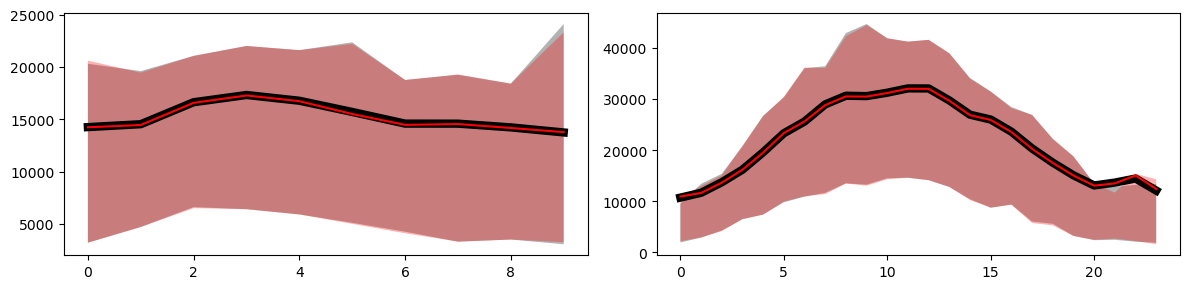

In [62]:
fig, axes = plt.subplots(1, 2, figsize=[12,3], dpi=100)
ax = axes[0]
ax.plot(xx_obs, avg1_pfarea_obs, 'k', lw=6)
ax.plot(xx_m1, avg1_pfarea_m1, 'r')
# Shading
qntl25 = qntl1_pfarea_obs.sel(quantile=0.25)
qntl75 = qntl1_pfarea_obs.sel(quantile=0.75)
ax.fill_between(xx_obs, qntl25, qntl75, facecolor='k', alpha=0.3)
qntl25 = qntl1_pfarea_m1.sel(quantile=0.25)
qntl75 = qntl1_pfarea_m1.sel(quantile=0.75)
ax.fill_between(xx_m1, qntl25, qntl75, facecolor='r', alpha=0.3)

ax = axes[1]
ax.plot(xx_obs, avg2_pfarea_obs, 'k', lw=6)
ax.plot(xx_m1, avg2_pfarea_m1, 'r')
# Shading
qntl25 = qntl2_pfarea_obs.sel(quantile=0.25)
qntl75 = qntl2_pfarea_obs.sel(quantile=0.75)
ax.fill_between(xx_obs, qntl25, qntl75, facecolor='k', alpha=0.3)
qntl25 = qntl2_pfarea_m1.sel(quantile=0.25)
qntl75 = qntl2_pfarea_m1.sel(quantile=0.75)
ax.fill_between(xx_m1, qntl25, qntl75, facecolor='r', alpha=0.3)
fig.tight_layout()

In [63]:
# Compute volume rainrate [unit: kg/h]
pfvolrain_obs = (dsobs_s.total_rain * pixel_radius_obs**2)
pfvolrain_m1 = (dsm1_s.total_rain * pixel_radius_m1**2)

avg1_vr_obs, qntl1_vr_obs, ns1_obs = get_comp_tracks_by1cond(pfvolrain_obs, ccslifetime_obs, lifetime_range1, quantiles)
avg1_vr_m1, qntl1_vr_m1, ns1_m1 = get_comp_tracks_by1cond(pfvolrain_m1, ccslifetime_m1, lifetime_range1, quantiles)

avg2_vr_obs, qntl2_vr_obs, ns2_obs = get_comp_tracks_by1cond(pfvolrain_obs, ccslifetime_obs, lifetime_range2, quantiles)
avg2_vr_m1, qntl2_vr_m1, ns2_m1 = get_comp_tracks_by1cond(pfvolrain_m1, ccslifetime_m1, lifetime_range2, quantiles)

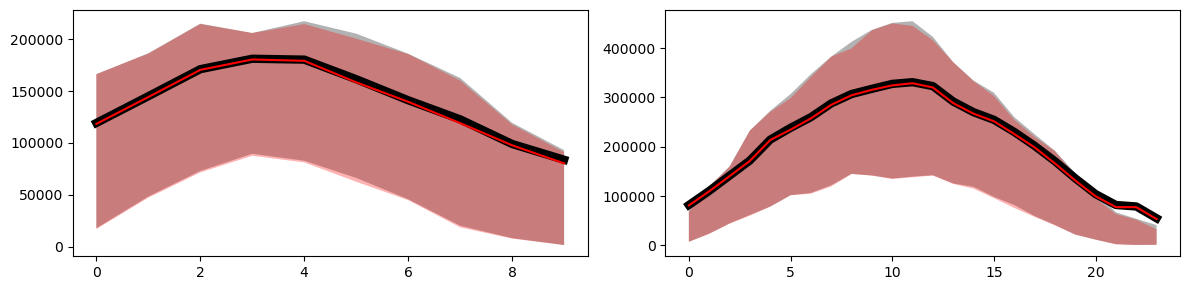

In [64]:
fig, axes = plt.subplots(1, 2, figsize=[12,3], dpi=100)
ax = axes[0]
ax.plot(xx_obs, avg1_vr_obs, 'k', lw=6)
ax.plot(xx_m1, avg1_vr_m1, 'r')
# Shading
qntl25 = qntl1_vr_obs.sel(quantile=0.25)
qntl75 = qntl1_vr_obs.sel(quantile=0.75)
ax.fill_between(xx_obs, qntl25, qntl75, facecolor='k', alpha=0.3)
qntl25 = qntl1_vr_m1.sel(quantile=0.25)
qntl75 = qntl1_vr_m1.sel(quantile=0.75)
ax.fill_between(xx_m1, qntl25, qntl75, facecolor='r', alpha=0.3)

ax = axes[1]
ax.plot(xx_obs, avg2_vr_obs, 'k', lw=6)
ax.plot(xx_m1, avg2_vr_m1, 'r')
# Shading
qntl25 = qntl2_vr_obs.sel(quantile=0.25)
qntl75 = qntl2_vr_obs.sel(quantile=0.75)
ax.fill_between(xx_obs, qntl25, qntl75, facecolor='k', alpha=0.3)
qntl25 = qntl2_vr_m1.sel(quantile=0.25)
qntl75 = qntl2_vr_m1.sel(quantile=0.75)
ax.fill_between(xx_m1, qntl25, qntl75, facecolor='r', alpha=0.3)
fig.tight_layout()

In [65]:
avg1_maxrr_obs, qntl1_maxrr_obs, ns1_obs = get_comp_tracks_by1cond(dsobs_s.pf_maxrainrate.isel(nmaxpf=0), ccslifetime_obs, lifetime_range1, quantiles)
avg1_maxrr_m1, qntl1_maxrr_m1, ns1_m1 = get_comp_tracks_by1cond(dsm1_s.pf_maxrainrate.isel(nmaxpf=0), ccslifetime_m1, lifetime_range1, quantiles)

avg2_maxrr_obs, qntl2_maxrr_obs, ns2_obs = get_comp_tracks_by1cond(dsobs_s.pf_maxrainrate.isel(nmaxpf=0), ccslifetime_obs, lifetime_range2, quantiles)
avg2_maxrr_m1, qntl2_maxrr_m1, ns2_m1 = get_comp_tracks_by1cond(dsm1_s.pf_maxrainrate.isel(nmaxpf=0), ccslifetime_m1, lifetime_range2, quantiles)

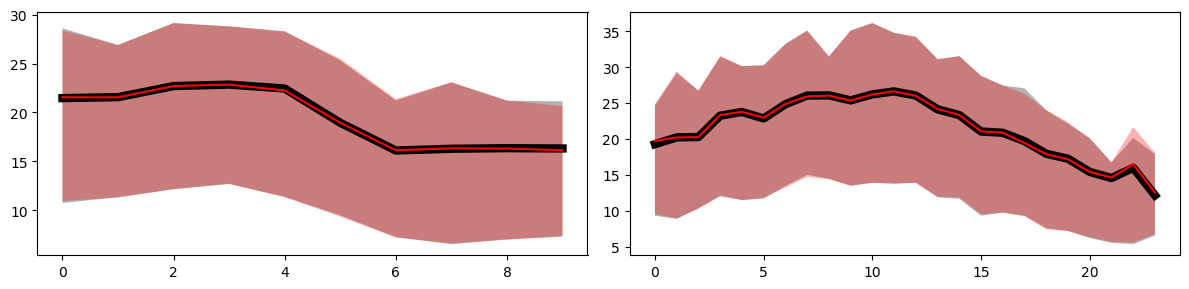

In [66]:
fig, axes = plt.subplots(1, 2, figsize=[12,3], dpi=100)
ax = axes[0]
ax.plot(xx_obs, avg1_maxrr_obs, 'k', lw=6)
ax.plot(xx_m1, avg1_maxrr_m1, 'r')
# Shading
qntl25 = qntl1_maxrr_obs.sel(quantile=0.25)
qntl75 = qntl1_maxrr_obs.sel(quantile=0.75)
ax.fill_between(xx_obs, qntl25, qntl75, facecolor='k', alpha=0.3)
qntl25 = qntl1_maxrr_m1.sel(quantile=0.25)
qntl75 = qntl1_maxrr_m1.sel(quantile=0.75)
ax.fill_between(xx_m1, qntl25, qntl75, facecolor='r', alpha=0.3)

ax = axes[1]
ax.plot(xx_obs, avg2_maxrr_obs, 'k', lw=6)
ax.plot(xx_m1, avg2_maxrr_m1, 'r')
# Shading
qntl25 = qntl2_maxrr_obs.sel(quantile=0.25)
qntl75 = qntl2_maxrr_obs.sel(quantile=0.75)
ax.fill_between(xx_obs, qntl25, qntl75, facecolor='k', alpha=0.3)
qntl25 = qntl2_maxrr_m1.sel(quantile=0.25)
qntl75 = qntl2_maxrr_m1.sel(quantile=0.75)
ax.fill_between(xx_m1, qntl25, qntl75, facecolor='r', alpha=0.3)
fig.tight_layout()

In [67]:
avg1_pfmaxis_obs, qntl1_pfmaxis_obs, ns1_obs = get_comp_tracks_by1cond(dsobs_s.pf_majoraxis.isel(nmaxpf=0), ccslifetime_obs, lifetime_range1, quantiles)
avg1_pfmaxis_m1, qntl1_pfmaxis_m1, ns1_m1 = get_comp_tracks_by1cond(dsm1_s.pf_majoraxis.isel(nmaxpf=0), ccslifetime_m1, lifetime_range1, quantiles)

avg2_pfmaxis_obs, qntl2_pfmaxis_obs, ns2_obs = get_comp_tracks_by1cond(dsobs_s.pf_majoraxis.isel(nmaxpf=0), ccslifetime_obs, lifetime_range2, quantiles)
avg2_pfmaxis_m1, qntl2_pfmaxis_m1, ns2_m1 = get_comp_tracks_by1cond(dsm1_s.pf_majoraxis.isel(nmaxpf=0), ccslifetime_m1, lifetime_range2, quantiles)

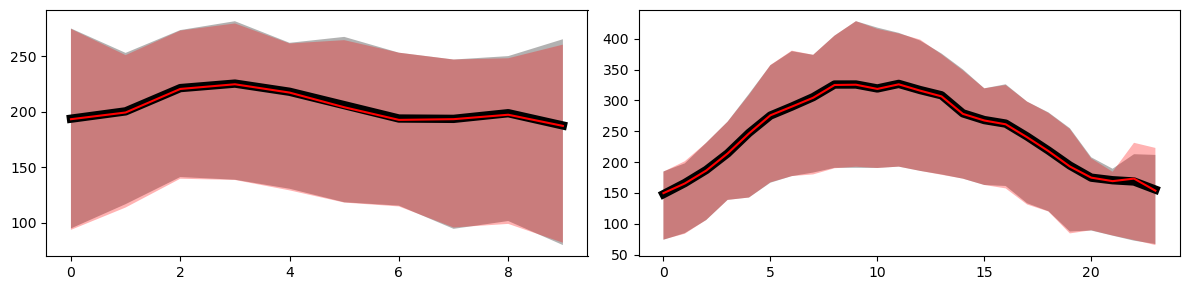

In [68]:
fig, axes = plt.subplots(1, 2, figsize=[12,3], dpi=100)
ax = axes[0]
ax.plot(xx_obs, avg1_pfmaxis_obs, 'k', lw=6)
ax.plot(xx_m1, avg1_pfmaxis_m1, 'r')
# Shading
qntl25 = qntl1_pfmaxis_obs.sel(quantile=0.25)
qntl75 = qntl1_pfmaxis_obs.sel(quantile=0.75)
ax.fill_between(xx_obs, qntl25, qntl75, facecolor='k', alpha=0.3)
qntl25 = qntl1_pfmaxis_m1.sel(quantile=0.25)
qntl75 = qntl1_pfmaxis_m1.sel(quantile=0.75)
ax.fill_between(xx_m1, qntl25, qntl75, facecolor='r', alpha=0.3)

ax = axes[1]
ax.plot(xx_obs, avg2_pfmaxis_obs, 'k', lw=6)
ax.plot(xx_m1, avg2_pfmaxis_m1, 'r')
# Shading
qntl25 = qntl2_pfmaxis_obs.sel(quantile=0.25)
qntl75 = qntl2_pfmaxis_obs.sel(quantile=0.75)
ax.fill_between(xx_obs, qntl25, qntl75, facecolor='k', alpha=0.3)
qntl25 = qntl2_pfmaxis_m1.sel(quantile=0.25)
qntl75 = qntl2_pfmaxis_m1.sel(quantile=0.75)
ax.fill_between(xx_m1, qntl25, qntl75, facecolor='r', alpha=0.3)
fig.tight_layout()